# Reverse time migration with COFII and AzureClusterlessHPC

This notebook demonstrates how to run reverse time migration (RTM) using Chevron's COFII framework and AzureClusterlessHPC. The original notebook based on scale sets can be found [here](https://github.com/ChevronETC/Examples/blob/main/60_rtm/02_rtm_DynamicParallel.ipynb). In the following version, we use AzureClusterlessHPC's macros to offload computations to Azure Batch.



## Set up

We start by setting the environment variables that point to our credentials and parameter files, which specifies our batch pool:

In [1]:
# Install required packages for this example
using Pkg
Pkg.add(["DistributedArrays", "DistributedOperations", "Schedulers", "PyPlot"])
Pkg.add(["Jets", "DistributedJets", "JetPack", "JetPackDSP", "WaveFD", "JetPackWaveFD"])

# Set paths to credentials + parameters
ENV["CREDENTIALS"] = joinpath(pwd(), "../..", "credentials.json")
ENV["PARAMETERS"] = joinpath(pwd(), "parameters.json")

# Load AzureClusterlessHPC
using AzureClusterlessHPC
batch_clear();

We start the batch pool and pass it the startup script that specifies all the required COFII-related packages as specified [here](https://github.com/ChevronETC/Examples/blob/main/00_add_packages/00_add_packages.ipynb). The packages are installed on all nodes in the batch pool.

In [2]:
startup_script = "pool_startup_script_cofii.sh"
create_pool_and_resource_file(startup_script);

Created pool 1 of 1 in southcentralus with 8 nodes.


## Prepare velocity models

Before diving into the imaging part, we load the true velocity model and create the migration velocity model by smoothing it slightly:

In [3]:
using Distributed, PyPlot, Jets, JetPack, JetPackDSP, Printf

In [4]:
# Read true velocity for data generation and migration velocity model
v_true = read!("../../data/marmousi_vp_20m_176x851.bin", Array{Float32}(undef, 176, 851))
nz,nx = 176,851
dz,dx = 10.0,10.0;

In [5]:
ns = 21
P = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=true)
M = JopMix(range(P), (7,7))
R = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=false)

s1 = R' ∘ M ∘ P * (1 ./ v_true)
v_smooth = 1 ./(s1);

The true seismic image is obtained as the vertical difference of the true model:

In [6]:
D = JopDifference(JetSpace(Float32,nz,nx), 1)
r1 = D * v_smooth;

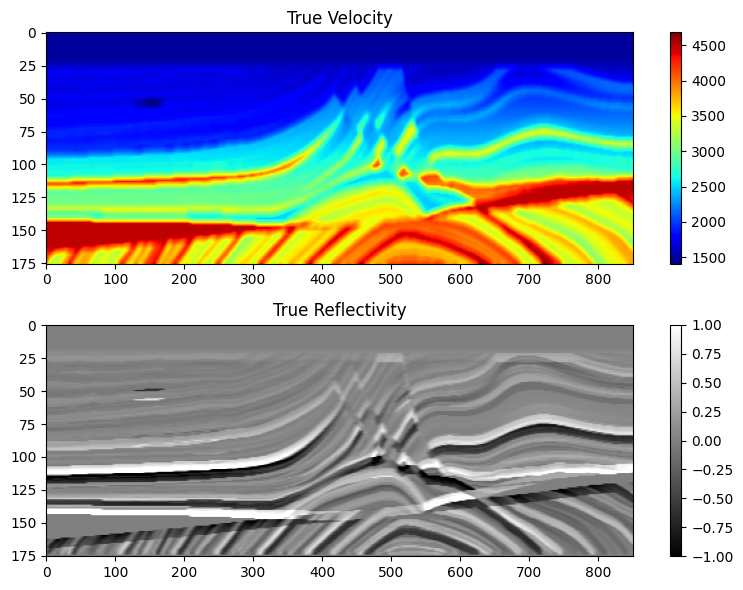

(vmin, vmax, rmax) = (1408.8602f0, 4681.3086f0, 461.5381f0)


In [7]:
vmin,vmax = extrema(v_smooth)
rmax = maximum(abs,r1)
@show vmin,vmax,rmax;
figure(figsize=(8,6)); clf()

subplot(2,1,1); imshow(v_smooth,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("True Velocity");

subplot(2,1,2); imshow(2 .* r1 ./ rmax,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-1,+1);
title("True Reflectivity");

tight_layout()

## Data modeling

With our true velocity model for generating seismic shot data and our migration velocity model in place, we not define our function to model the observed data that is subsequently used for imaging. First, we load all required packages and tag the expression with the `@batchdef` macro to specify that all packages, variables and functions are also defined on the remote batch workers.

In [8]:
@batchdef using Distributed, DistributedArrays, DistributedJets, DistributedOperations
@batchdef using Jets, JetPack, WaveFD, JetPackWaveFD, Random, LinearAlgebra;

We enable thread pinning on the batch nodes through Julia environment variables.

In [9]:
# Set OMP environment variables
@batchdef begin
    nthread = Sys.CPU_THREADS
    ENV["OMP_DISPLAY_ENV"] = "true"
    ENV["OMP_PROC_BIND"] = "close"
    ENV["OMP_NUM_THREADS"] = "$(div(nthread,2))"
end;

Next, we create a set of source locations for which the seismic data will be generated. Here, we create 20 source locations:

In [10]:
# Create list of shots
nshots = 20
sx = round.(Int,collect(range(0,stop=(nx-1)*dx,length=nshots)))
@show nshots
@show sx;

nshots = 20
sx = [0, 447, 895, 1342, 1789, 2237, 2684, 3132, 3579, 4026, 4474, 4921, 5368, 5816, 6263, 6711, 7158, 7605, 8053, 8500]


For the modeling and imaging part, we have to supply a directory in which temporary wavefield files will be written to disk:

In [11]:
# Scratch space for temp files
@batchdef scratch = pwd()
@batchdef isdir(scratch);

We now specify the number of time steps and sampling intervals for the data and for finite-difference modeling:

In [12]:
# Modeling parameters
@batchdef begin
    ntrec = 2001
    dtrec = 0.002
    dtmod = 0.001
end;

Next, we implement our forward modeling function, which takes the source number `isrc`, as well as grid parameters and a batch future `_v` of the velocity model as input arguments. The batch future can be retrieved by calling the `fetch` function on the future:

In [13]:
# Modeling function
@batchdef function modelshot(isrc,nz,nx,dz,dx,_v,sx)
    @info "modeling shot $(isrc) on $(gethostname()) with id $(myid())..."
    F = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=10.0),
        sx = sx[isrc],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        srcfieldfile = joinpath(scratch, "field-$isrc-$(randstring()).bin"),
        reportinterval=0)

    d = F*fetch(_v) # read model into memory via fetch
    close(F) # delete scratch files that we don't need anymore

    return d
end;

We now broadcast the true velocity model to the batch workers. The `@bcast` macro uploads the model to blob storage, creates a batch resource file and returns a batch future that can be passed to the modeling function (and avoids repeatedly copying the model to every task). We then execute the modeling function as a multi-task batch job by using the `@batchexec` macro in combination with `pmap`. The function call returns a batch controller with basic job parameters, as well as futures to the results (stored in blob).

In [14]:
# Generate data
_v_true = @bcast(v_true)
bctrl = @batchexec pmap(isrc -> modelshot(isrc, nz, nx, dz, dx, _v_true, sx), 1:nshots);

  6.612073 seconds (3.84 M allocations: 231.249 MiB, 1.59% gc time, 29.37% compilation time)


We wait for all tasks to finish. Rather than fetching the result, we collect the results in the form of a `BlobFuture`, which we can subsequently pass to our RTM function. This avoids moving the modeled data between the blob storage and the local machine.

In [15]:
# Wait for tasks to finish
wait_for_tasks_to_complete(bctrl)
d_futures = bctrl.output
delete_job(bctrl);

Uploading file v_true.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_AMOiNApx_1]...
Uploading file /home/pwitte/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/pwitte/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterlesstemp]...
Uploading file task_8.dat to container [azureclusterlesstemp]...
Uploading file task_9.dat to container [azurecl

## Reverse time migration

In this section, we define our RTM function and apply it to the seismic data that we modeled in the previous section. Before imaging the data, we apply a topmute function to mute the direct wave, which is specified as follows:

In [16]:
# Data topmute
@batchdef function timemute!(F, d, watervel, tmute)
    for i = 1:length(state(F, :rx)) 
        rx = state(F, :rx)
        rz = state(F, :rz)
        sx = state(F, :sx)
        sz = state(F, :sz)
        dist = sqrt((sx[1] - rx[i])^2 + (sz[1] - rz[i])^2)
        time = dist / watervel
        tbeg = 1
        tend = round(Int, (time + tmute) / state(F,:dtrec))
        tend = clamp(tend,1,size(d,1))
        d[tbeg:tend,i] .= 0
    end
    nothing
end;

Finally, we implement our `migrateshot` function, which first models a seismic shot record for a given source index `isrc` and then images it. The function applies the time mute to the data before imaging it and returns both the image as well as an array for illumination compensation:

In [17]:
# Migrate shot function
@batchdef function migrateshot(isrc,nz,nx,dz,dx,_d,_v,sx)
    @info "migrating shot $(isrc) on $(gethostname()) with id $(myid())..."
    F = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=10.0),
        sx = sx[isrc],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        srcfieldfile = joinpath(scratch, "field-$isrc-$(randstring()).bin"),
        reportinterval=0)
    
    d = fetch(_d)
    v = reshape(fetch(_v), nz, nx, 1)
    timemute!(F, d, 1500, 2/16) # mute out the direct and diving waves
    J = jacobian!(F, v)
    illum = srcillum(J)
    m = J'*d
    close(F) # delete scratch files that we don't need anymore

    return m, illum
end;

Before evaluating our function, we broadcast the migration velocity model to the batch workers:

In [18]:
_v_smooth = @bcast(v_smooth);

As before, we use the `@batchexec` macro in combination with Julia's `pmap` function, to run our RTM function as a multi-task Azure Batch job:

In [19]:
# Run RTM
bctrl = @batchexec pmap(isrc -> migrateshot(isrc, nz, nx, dz, dx, d_futures[isrc], _v_smooth, sx), 1:nshots);

  2.751435 seconds (87.92 k allocations: 6.172 MiB, 3.14% compilation time)


Next, we wait for the batch job to finish and collect the results. We can fetch and sum the output images by using the `fetchreduce` function, which applies a specified operation to the return arguments of the executed function:

In [20]:
m, illum = fetchreduce(bctrl; op=+);  # Blocking

# Remove singleton dimension
m = m[:,:,1]
illum = illum[:,:,1];

Monitoring tasks for 'Completed' state, timeout in 60 minutes ...
Uploading file v_smooth.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_VIpZe70t_1]...
Uploading file /home/pwitte/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/pwitte/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterlesstemp]...
Uploading file task_8.dat to container [azur

Before plotting the result, we apply some basic post processing to the image. This includes a vertical derivative, as well as illumination compensation and muting of the water column.

In [21]:
L = JopLaplacian(JetSpace(Float32,nz,nx));

In [22]:
# Illumination compensation
g = ([0:(nz-1);]*dz).^2 * ones(1,nx)
img = g .* (L * m) ./ (illum .+ 1e-8 * maximum(abs, illum))
@show extrema(img);

extrema(img) = (-4.412426801629526, 7.357301357348528)


In [23]:
# Mute water column
img[v_true.==1500.0] .= 0
mrms1 = 3.5 * sqrt(norm(img)^2 / length(img));

Finally, we plot the migrated image and compare it to the true reflectivity:

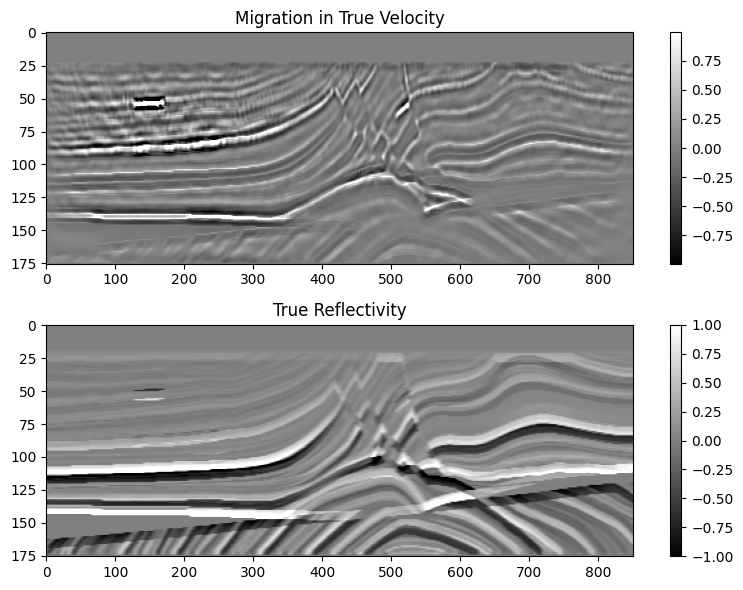

In [24]:
# Plot
figure(figsize=(8,6)); clf()

subplot(2,1,1); imshow(img,aspect="auto",cmap="gray")
colorbar(orientation="vertical");clim(-mrms1,+mrms1)
title("Migration in True Velocity")

subplot(2,1,2); imshow(2 .* r1 ./ rmax,aspect="auto",cmap="gray")
colorbar(orientation="vertical");clim(-1,+1)
title("True Reflectivity")

tight_layout();

The last step is the clean up step, in which we delete the job, the temporary blob container and the batch pool:

In [25]:
destroy!(bctrl);

## Copyright

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License (MIT). See LICENSE in the repo root for license information.